<a href="https://colab.research.google.com/github/Meyssemmedini/food-sales-predictions/blob/main/Food_Sales_prediction_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Packages

In [80]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
# Import modeling tools
import missingno
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_absolute_error , mean_squared_error , r2_score


In [81]:
# set the default output to pandas
from sklearn import set_config
set_config(transform_output='pandas')
pd.set_option('display.max_columns',100)


# step 1 : Load the Data

In [82]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [83]:
filename = ('/content/drive/MyDrive/coding dojo/data sets/sales_predictions_2023.csv')
df = pd.read_csv( filename)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [84]:
#n the dimensions of the DataFrame. (rows, columns)
df.shape

(8523, 12)

#Step 2 : Explore the Data

In [85]:
#Count the number of duplicate rows in a DataFrame.
df.duplicated().sum()
if df.duplicated().sum() == 0:
  print("there is no duplicated rows in our dataframe")

there is no duplicated rows in our dataframe


In [86]:
#identifiying the missing data
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

##dealing with missing data

### For Item_Weight

In [87]:
percent_missing = df['Item_Weight'].isna().sum() / df.shape[0]
'{:.0%}'.format(percent_missing)

'17%'

We choose not to exclude rows despite the presence of a considerable amount of missing data. Additionally, we refrain from removing entire columns, as the extent of missing values does not justify such exclusion. Instead, we intend to address the missing data by imputing the mean values

In [88]:
df['Item_Weight'].fillna(value =df['Item_Weight'].mean(),inplace=True )

In [89]:
df.isna().sum()

Item_Identifier                 0
Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

or we can fill the missing Item_Weight with the mean of each Item_Type that correspond to it .

### For Outlet_Size

In [90]:
percent_missing2 = df['Outlet_Size'].isna().sum() / df.shape[0]
'{:.0%}'.format(percent_missing2)

'28%'

We choose to retain all rows despite the notable presence of missing data, and we abstain from discarding entire columns as the absence of values in these columns does not meet the threshold for removal.


In [91]:
# Check the unique values and counts of the 'Outlet_Sizee' column
df['Outlet_Size'].value_counts()

Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64

In [92]:
df['Outlet_Type'].value_counts()

Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: Outlet_Type, dtype: int64

looking for a relation between the two columns outlet_size and outlet_type

In [93]:
type_medium_outlet= (df['Outlet_Size'] == "Medium")  &  ( df['Outlet_Type'] )
df[type_medium_outlet]['Outlet_Type'].value_counts()

Supermarket Type3    935
Supermarket Type1    930
Supermarket Type2    928
Name: Outlet_Type, dtype: int64

In [94]:
type_small_outlet= (df['Outlet_Size'] == "Small")  &  ( df['Outlet_Type'] )
df[type_small_outlet]['Outlet_Type'].value_counts()

Supermarket Type1    1860
Grocery Store         528
Name: Outlet_Type, dtype: int64

In [95]:
type_High_outlet= (df['Outlet_Size'] == "High")  &  ( df['Outlet_Type'] )
df[type_High_outlet]['Outlet_Type'].value_counts()

Supermarket Type1    932
Name: Outlet_Type, dtype: int64

we are going to Impute Missing Values of Outlet_Size based on the
realtion between Outlet_Type and Outlet_Size

In [96]:
#filling the rows that have Outlet_Type' == 'Supermarket Type1' with Outlet_Size' = 'High'
condition_1 = df['Outlet_Type'] == 'Supermarket Type1'
if condition_1.any():
    df.loc[condition_1, 'Outlet_Size'] = df.loc[condition_1, 'Outlet_Size'].fillna('High')

In [97]:
#filling the rows that have Outlet_Type' == 'Grocery Store' with Outlet_Size' = 'Small'

condition_2 = df['Outlet_Type'] == 'Grocery Store'
if condition_2.any():
    df.loc[condition_2, 'Outlet_Size'] = df.loc[condition_2, 'Outlet_Size'].fillna('Small')

In [98]:
#filling the rest with Medium
df.fillna('Medium', inplace=True)

In [99]:
#Confirm that there are no more missing values after addressing them
df.isna().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

## Check for Inconsistencies in Categorical Values

In [100]:
# Check the unique values and counts of the 'Item_Fat_Content' column
df['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [101]:
# Standardize the values in the Item_Fat_Content column
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace(['LF','low fat'], 'Low Fat')
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('reg', 'Regular')

In [102]:
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

## checking for inconsistencies in data points

In [103]:
#Generate descriptive statistics of numerical columns.
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.226124,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,9.310000,0.026989,93.826500,1987.000000,834.247400
50%,12.857645,0.053931,143.012800,1999.000000,1794.331000
75%,16.000000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


## Data Visualisation

###Exploratory Data Viz

#### Histogram

creating Histograms to view the distributions of features in the data


<ipython-input-104-f7167bc40eaf>:2: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



Text(0, 0.5, 'Count')

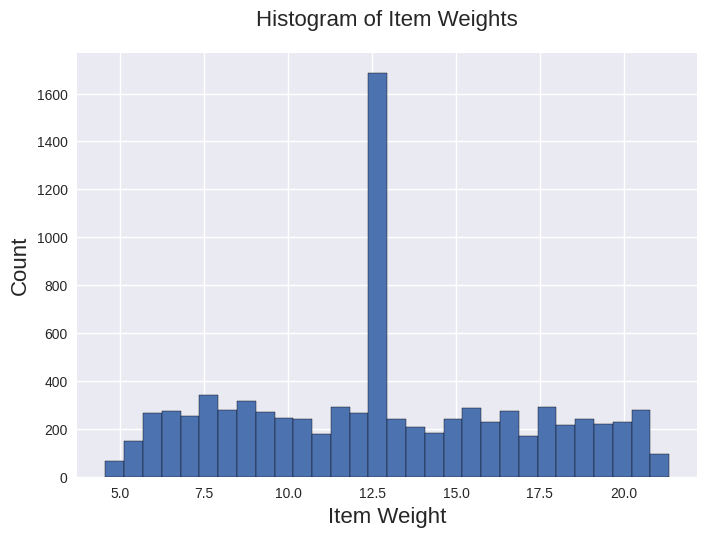

In [104]:
#creating Histogram plot of Item Weights with matplotlib
plt.style.use('seaborn');
df['Item_Weight'].hist(bins = 30, edgecolor='black');
plt.ticklabel_format(useOffset=False, style='plain');
plt.title('Histogram of Item Weights', fontsize=16, pad = 20)
plt.xlabel('Item Weight', fontsize=16)
plt.ylabel('Count', fontsize=16)

Text(0.5, 1.0, 'Histogram of Item Visibility')

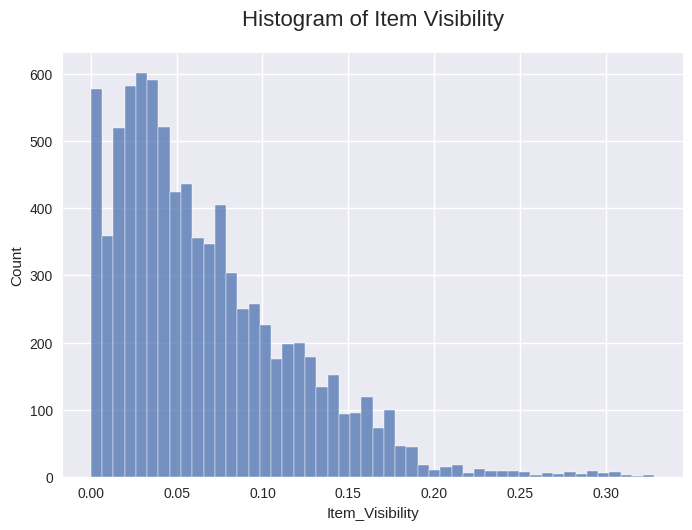

In [105]:
#creating Histogram plot of Item_Visibility with seaborn

sns.histplot(data=df, x='Item_Visibility', y=None, hue=None,  stat='count', bins='auto');

plt.title('Histogram of Item Visibility', fontsize=16, pad = 20)



Text(0.5, 1.0, 'Histogram of Outlet Sales')

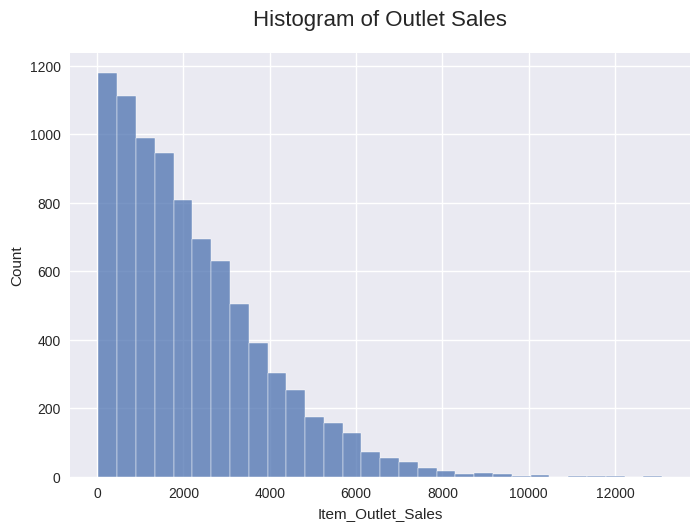

In [106]:
#creating Histogram plot of f Outlet Sales with seaborn
sns.histplot(data=df, x='Item_Outlet_Sales', y=None, hue=None,  stat='count', bins=30);
plt.title('Histogram of Outlet Sales', fontsize=16, pad = 20)


####Boxplot

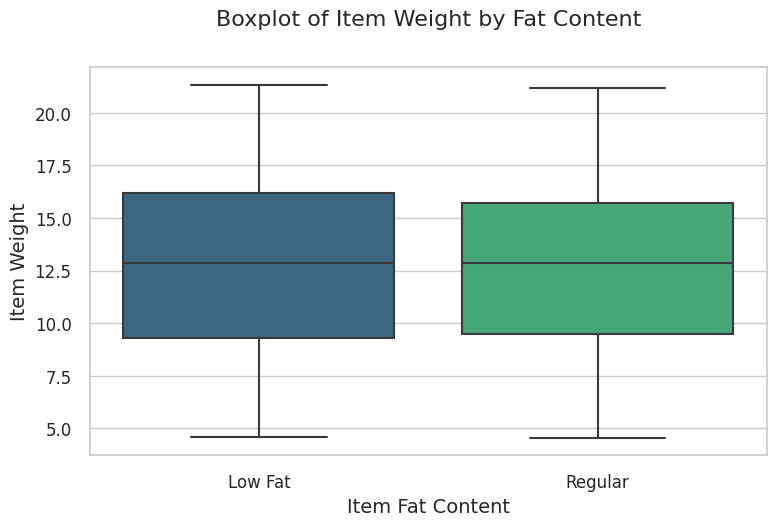

In [107]:
# creating Boxplot of Item Weight by Fat Content with seaborn
# Set seaborn style
sns.set(style='whitegrid', font_scale=1.2)

# Create the boxplot
sns.boxplot(data=df, x='Item_Fat_Content', y='Item_Weight', palette='viridis')

# Set labels and title
plt.xlabel('Item Fat Content', fontsize=14)
plt.ylabel('Item Weight', fontsize=14)
plt.title('Boxplot of Item Weight by Fat Content', fontsize=16, pad = 30)

# Adjust tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adjust the figure layout to prevent clipping of labels
plt.tight_layout()

# Show the plot
plt.show()


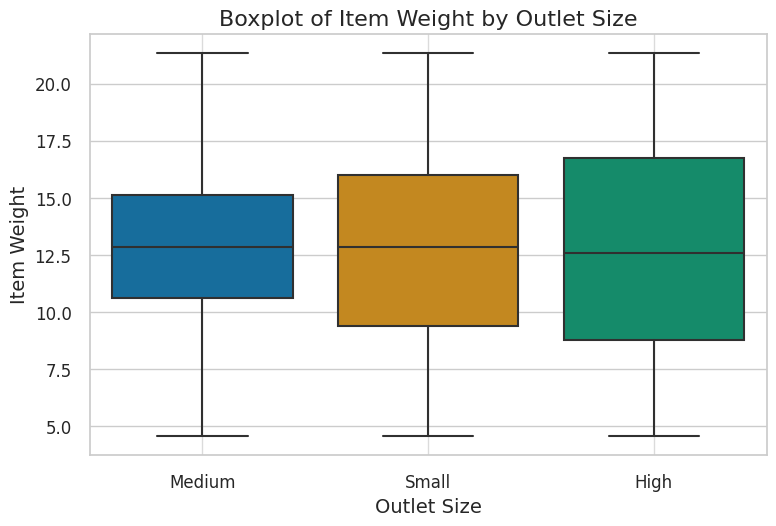

In [108]:
# creating Boxplot of Item Weight by Outlet Size with seaborn
sns.set(style='whitegrid', font_scale=1.2)

sns.boxplot(data=df, x='Outlet_Size', y='Item_Weight', palette='colorblind')


plt.xlabel('Outlet Size', fontsize=14)
plt.ylabel('Item Weight', fontsize=14)
plt.title('Boxplot of Item Weight by Outlet Size', fontsize=16)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add vertical grid lines
plt.grid(axis='x', linestyle='-', alpha=0.7)


plt.tight_layout()


plt.show()


####Heatmap

In [109]:
# the correlation matrix
corr = df.corr()
corr

<ipython-input-109-7be8ebe5a351>:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
Item_Weight,1.000000,-0.012049,0.024756,-0.008301,0.011550
Item_Visibility,-0.012049,1.000000,-0.001315,-0.074834,-0.128625
Item_MRP,0.024756,-0.001315,1.000000,0.005020,0.567574
Outlet_Establishment_Year,-0.008301,-0.074834,0.005020,1.000000,-0.049135
Item_Outlet_Sales,0.011550,-0.128625,0.567574,-0.049135,1.000000


<Axes: >

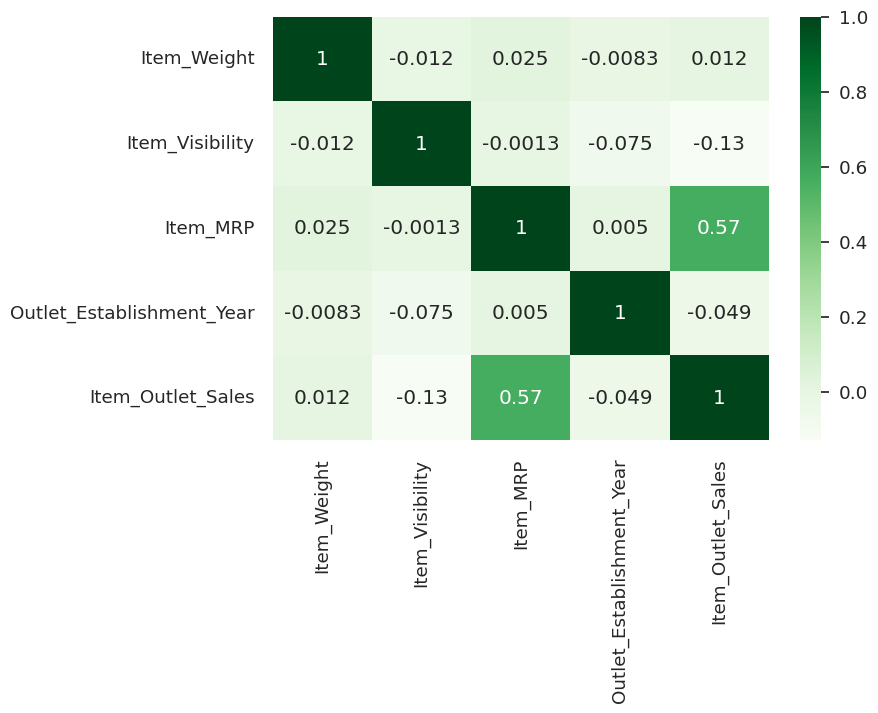

In [110]:
# Generating the heatmap with seaborn
sns.heatmap(corr, cmap = 'Greens', annot = True)

### Explanatory Data Viz

####Pie Chart



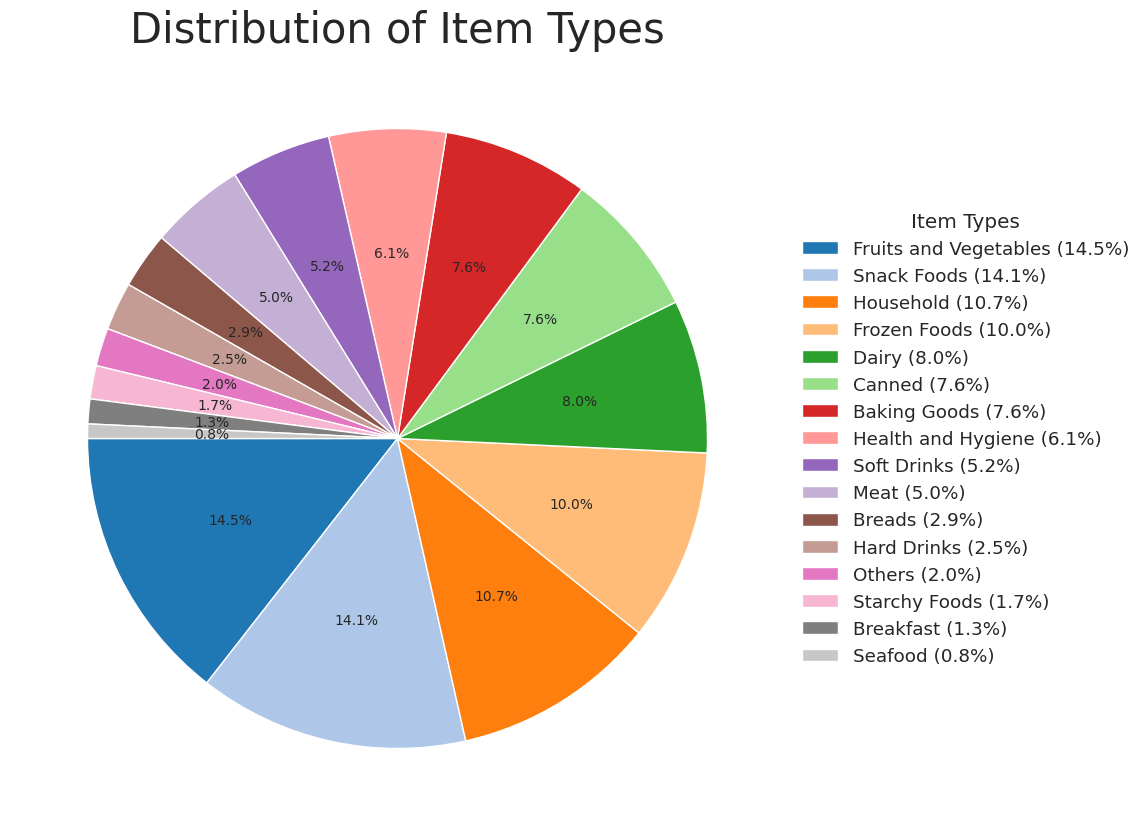

In [112]:
# creating pie chart of Distribution of Item Types with
# Count the occurrences of each item type
item_type_counts = df['Item_Type'].value_counts()
# Plotting a pie chart
fig, ax = plt.subplots(figsize=(10, 20))
wedges, texts, autotexts = ax.pie(item_type_counts, autopct='%1.1f%%', startangle=180, colors = plt.cm.tab20.colors ,textprops=dict(fontsize=10))
# Rotate the percentage labels inside the pie chart
for autotext in autotexts:
    autotext.set(rotation= 'horizontal', ha='center', va='center' )
# Adding legend
legend_labels = [f'{label} ({percent:.1f}%)' for label, percent in zip(item_type_counts.index, item_type_counts / item_type_counts.sum() * 100)]
ax.legend(wedges, legend_labels, title="Item Types", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.title('Distribution of Item Types',fontsize=30, ha='center', va='top')
plt.show()


####Bar Chart

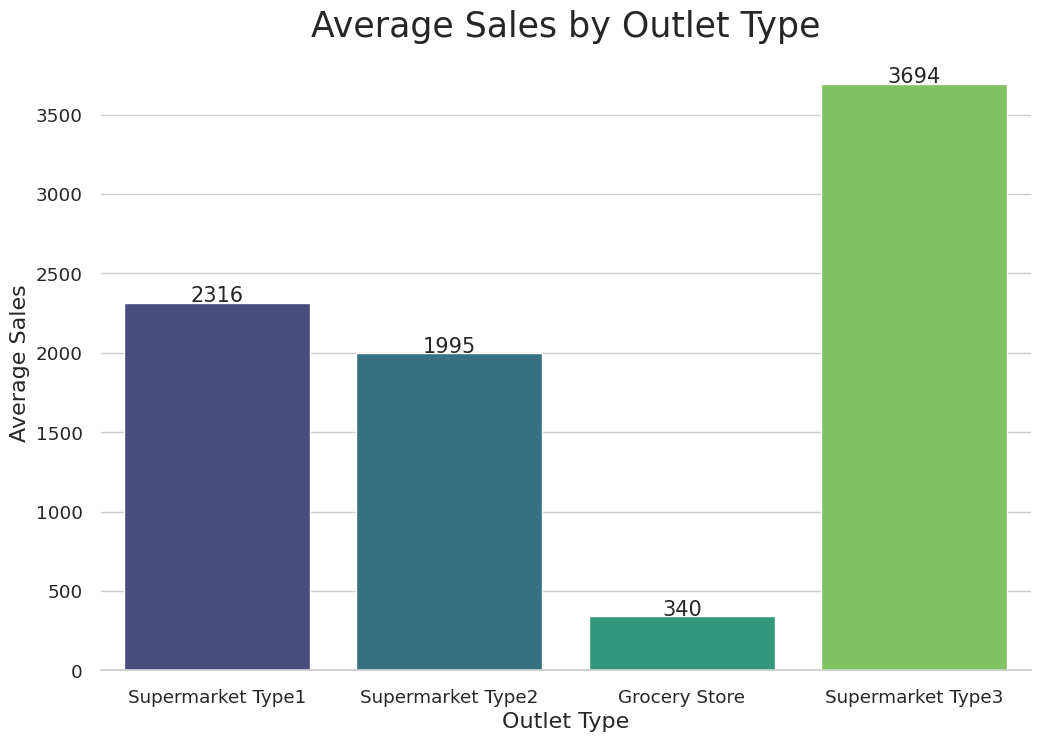

In [113]:
# creating bar chart of Average Sales by Outlet Type with seaborn
plt.figure(figsize=(12, 8))
ax=sns.barplot(data=df, x='Outlet_Type', y='Item_Outlet_Sales',  palette='viridis', errorbar=None)
# annote
for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.0f'),
                (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                ha='center', va='center',
                size=15, xytext=(0, 5),
                textcoords='offset points')

sns.despine(left=True)
plt.title('Average Sales by Outlet Type',fontsize=25, ha='center', va='center', pad = 20)
plt.xlabel('Outlet Type',fontsize=16)
plt.ylabel('Average Sales',fontsize=16)
plt.show()


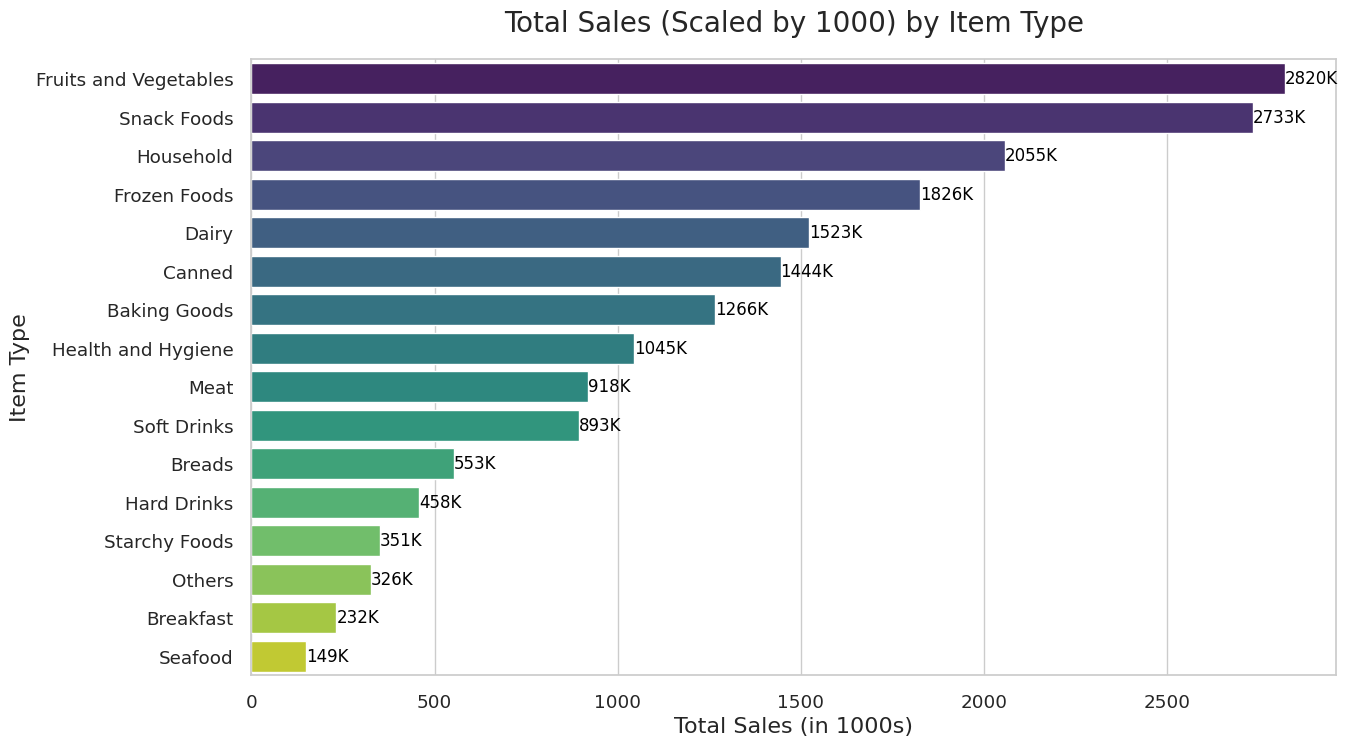

In [114]:
# Calculate total sales for each item type
total_sales_by_item_type = df.groupby('Item_Type')['Item_Outlet_Sales'].sum().sort_values(ascending=False)

# Scale down total sales by dividing by 1000
total_sales_scaled = total_sales_by_item_type / 1000

# Bar plot for scaled total sales by item type
plt.figure(figsize=(14, 8))
ax = sns.barplot(x=total_sales_scaled.values, y=total_sales_scaled.index, palette='viridis')

# Adding annotations with formatted scaled total sales values
for i, value in enumerate(total_sales_scaled.values):
    ax.text(value, i, f'{value:.0f}K', va='center', fontsize=12, color='black')

# Adding title and labels
plt.title('Total Sales (Scaled by 1000) by Item Type', fontsize=20, pad = 20)
plt.xlabel('Total Sales (in 1000s)', fontsize=16)
plt.ylabel('Item Type', fontsize=16)

plt.show()


####express scatterplot

In [115]:
#creating an express scatterplot (Dashboard-style Visualizations) with plotly express
#coustomizing color paltte
custom_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                  '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
                  '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5', '#c49c94']

fig = px.scatter(df, x='Item_Outlet_Sales', y='Item_Visibility', color='Item_Type',
                 color_discrete_sequence=custom_palette)
fig.update_layout(title='Dashboard of Item_Outlet_Sales and Item_Visibility')
fig.show()


####count plot

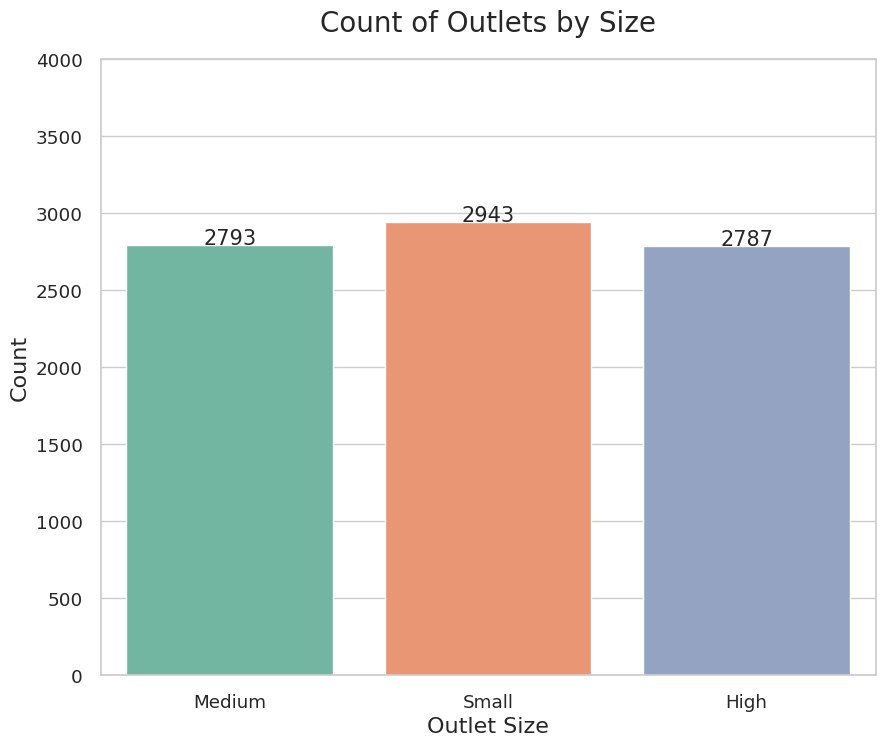

In [116]:
# Count plot for Outlet Size
plt.figure(figsize=(10, 8))
ax = sns.countplot(data=df, x='Outlet_Size', palette='Set2')
# annote
for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.0f'),
                (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                ha='center', va='center',
                size=15, xytext=(0, 5),
                textcoords='offset points')
ax.set_ylim(0, 4000)
# Adding title and labels
plt.title('Count of Outlets by Size', fontsize=20, pad = 20)
plt.xlabel('Outlet Size', fontsize=16)
plt.ylabel('Count', fontsize=16)

plt.show()


####Treemap



In [117]:
#creating treemap of Item_Outlet_Sales by Item_Type and Outlet_Type with plottly express
fig = px.treemap(df, path=['Item_Type', 'Outlet_Type'], values='Item_Outlet_Sales')

fig.update_layout(title='Treemap of Item_Outlet_Sales by Item_Type and Outlet_Type')
fig.show()


#Machine learning Part

##loading data

In [118]:
df = pd.read_csv('/content/drive/MyDrive/coding dojo/data sets/sales_predictions_2023.csv')
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


##Performing Preprocessing Steps

In [119]:
# Checking for Duplicates
df.duplicated().sum()

0

In [120]:
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [121]:
# Check the unique values and counts of the 'Item_Fat_Content' column
df['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [122]:
# Standardize the values in the Item_Fat_Content column
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace(['LF','low fat'], 'Low Fat')
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('reg', 'Regular')

In [123]:
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [124]:
#Generate descriptive statistics of numerical columns.
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [125]:
#droping 'Item_Identifier' column due to high cardinality,
df = df.drop(columns='Item_Identifier')

##Step 3 splitting the data into train and test


In [126]:
# The target we are trying to predict
y = df['Item_Outlet_Sales']
# The features we will use to make the prediction
X = df.drop(columns = 'Item_Outlet_Sales')

In [127]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Step 4 data preprocessing and transformation

###Making a Preprocessing Pipeline

In [128]:
X_test.columns

Index(['Item_Weight', 'Item_Fat_Content', 'Item_Visibility', 'Item_Type',
       'Item_MRP', 'Outlet_Identifier', 'Outlet_Establishment_Year',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')

In [129]:
#Create lists of column names
numeric_cols = X_train.select_dtypes("number").columns
categorical_cols= ['Item_Fat_Content','Item_Type','Outlet_Identifier','Outlet_Type',]
ordinal_cols = ['Outlet_Size','Outlet_Location_Type']
numeric_cols

Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')

In [130]:
# instantiate preprocessors
impute_mean = SimpleImputer(strategy='mean')
# instantiate scaler
scaler = StandardScaler()

In [131]:
num_pipe = make_pipeline(impute_mean, scaler)
num_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler())])

In [132]:
# Instantiate the individual preprocessors
categorical_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

In [133]:
cat_pipe = make_pipeline(categorical_encoder)
cat_pipe

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

In [134]:
#Imputing null values
impute_most_freq = SimpleImputer(strategy='most_frequent')
# Specifying the order of categories for our  Ordinal  Columms
Outlet_Size_order = ['Small','Medium', 'High']
Outlet_Location_Type_order = ['Tier 1' ,'Tier 2','Tier 3']
#Use OrdinalEncoder to encode the "shelf" column.
ordinal_encoder = OrdinalEncoder(categories=([Outlet_Size_order,Outlet_Location_Type_order]))
# Making a final scaler to scale category #'s
scaler_ord = StandardScaler()

In [135]:
## Making an ord_pipe
ord_pipe = make_pipeline(impute_most_freq, ordinal_encoder, scaler_ord)
ord_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('ordinalencoder',
                 OrdinalEncoder(categories=[['Small', 'Medium', 'High'],
                                            ['Tier 1', 'Tier 2', 'Tier 3']])),
                ('standardscaler', StandardScaler())])

In [136]:
#Create a tuple for each transformer with the: name, the transformer object, and the list of columns.
numeric_tuple = ('numeric', num_pipe, numeric_cols)
categorical_tuple = ('categorical',cat_pipe, categorical_cols)
ordinal_tuple = ('ordinal', ord_pipe, ordinal_cols)

In [137]:
#create a ColumnTransformer with verbose_feature_names_out set to False
col_transformer= ColumnTransformer(
    transformers=[numeric_tuple,categorical_tuple, ordinal_tuple],
    verbose_feature_names_out=False )
col_transformer

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Item_Fat_Co...'Item_Type',
                                  'Outlet_Identifier', 'Outlet_Type']),
                                ('ordinal',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['Small',
                                                                              'Medium',
                                                                              'High'],
                                                                             ['Tier '
                                                                              '1',
                                                                              'Tier '
                                                                              '2',
                                                                              'Tier '
                                                                              '3']])),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['Outlet_Size', 'Outlet_Location_Type'])],
                  verbose_feature_names_out=False)

In [138]:
# Fit on training data
col_transformer.fit(X_train)

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Item_Fat_Co...'Item_Type',
                                  'Outlet_Identifier', 'Outlet_Type']),
                                ('ordinal',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['Small',
                                                                              'Medium',
                                                                              'High'],
                                                                             ['Tier '
                                                                              '1',
                                                                              'Tier '
                                                                              '2',
                                                                              'Tier '
                                                                              '3']])),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['Outlet_Size', 'Outlet_Location_Type'])],
                  verbose_feature_names_out=False)

###Transform the training and test data


In [139]:
# Transform the training data
X_train_transformed = col_transformer.transform(X_train)
# Transform the testing data
X_test_transformed = col_transformer.transform(X_test)
# View the processed training data
X_train_transformed.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Identifier_OUT010,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Outlet_Size,Outlet_Location_Type
4776,0.817249,-0.712775,1.828109,1.327849,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.287374,1.084948
7510,0.556340,-1.291052,0.603369,1.327849,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.287374,1.084948
5828,-0.131512,1.813319,0.244541,0.136187,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.287374,-1.384777
5327,-1.169219,-1.004931,-0.952591,0.732018,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.384048,-0.149914
4810,1.528819,-0.965484,-0.336460,0.493686,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.287374,-0.149914


####Check the transformed training data:


In [140]:
#Confirm that all columns are numeric dtypes.
X_train_transformed.dtypes

Item_Weight                        float64
Item_Visibility                    float64
Item_MRP                           float64
Outlet_Establishment_Year          float64
Item_Fat_Content_Low Fat           float64
Item_Fat_Content_Regular           float64
Item_Type_Baking Goods             float64
Item_Type_Breads                   float64
Item_Type_Breakfast                float64
Item_Type_Canned                   float64
Item_Type_Dairy                    float64
Item_Type_Frozen Foods             float64
Item_Type_Fruits and Vegetables    float64
Item_Type_Hard Drinks              float64
Item_Type_Health and Hygiene       float64
Item_Type_Household                float64
Item_Type_Meat                     float64
Item_Type_Others                   float64
Item_Type_Seafood                  float64
Item_Type_Snack Foods              float64
Item_Type_Soft Drinks              float64
Item_Type_Starchy Foods            float64
Outlet_Identifier_OUT010           float64
Outlet_Iden

In [141]:
#Confirm that the original numeric features have been scaled.
X_train_transformed.describe().round(2)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Identifier_OUT010,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Outlet_Size,Outlet_Location_Type
count,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.0,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00
mean,0.00,-0.00,0.00,-0.00,0.65,0.35,0.07,0.03,0.01,0.08,0.08,0.1,0.15,0.03,0.06,0.11,0.05,0.02,0.01,0.14,0.05,0.02,0.06,0.11,0.11,0.11,0.06,0.11,0.11,0.11,0.11,0.11,0.12,0.65,0.11,0.11,-0.00,0.00
std,1.00,1.00,1.00,1.00,0.48,0.48,0.26,0.16,0.11,0.26,0.27,0.3,0.36,0.16,0.24,0.31,0.21,0.14,0.08,0.35,0.22,0.14,0.25,0.31,0.31,0.31,0.24,0.32,0.31,0.31,0.31,0.31,0.33,0.48,0.31,0.32,1.00,1.00
min,-1.98,-1.29,-1.77,-1.53,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.38,-1.38
25%,-0.81,-0.76,-0.76,-1.29,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.38,-1.38
50%,0.00,-0.23,0.03,0.14,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.29,-0.15
75%,0.76,0.56,0.72,0.73,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.29,1.08
max,2.00,5.13,1.99,1.33,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.96,1.08


##Step 5 creating and training the model


###Build a linear regression model.


In [142]:
# Instantiate model
lin_reg = LinearRegression()
#Fit model
lin_reg.fit(X_train_transformed, y_train)

LinearRegression()

In [143]:
#Get predictions for training and test data
y_pred_train = lin_reg.predict(X_train_transformed)
y_pred_test = lin_reg.predict(X_test_transformed)

###Evaluate the model

In [144]:
# Calculating RMSE with sklearn
train_RMSE = mean_squared_error(y_train, y_pred_train, squared=False)
test_RMSE = mean_squared_error(y_test, y_pred_test, squared=False)
print(f'Model Training RMSE: {train_RMSE:,.2f}')
print(f'Model Testing RMSE: {test_RMSE:,.2f}')

Model Training RMSE: 1,139.10
Model Testing RMSE: 1,092.90


In [145]:
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)
print(f'Model Training R2: {train_r2:.2f}')
print(f'Model Testing R2: {test_r2:.2f}')

Model Training R2: 0.56
Model Testing R2: 0.57


###build a regression tree model to predict sales

In [146]:
# Instantiate model
dec_tree = DecisionTreeRegressor(random_state = 42)
#  Fit the model on the training data only
dec_tree.fit(X_train_transformed, y_train)

DecisionTreeRegressor(random_state=42)

In [147]:
# Make predictions for training and testing data
train_preds = dec_tree.predict(X_train_transformed)
test_preds = dec_tree.predict(X_test_transformed)

###Evaluate the model

In [148]:
# evaluate the model
train_score = r2_score(y_train, train_preds)
test_score = r2_score(y_test, test_preds)
print(f'Model Training R2: {train_score:.2f}')
print(f'Model Testing R2: {test_score:.2f}')


Model Training R2: 1.00
Model Testing R2: 0.18


In [149]:
# Calculating RMSE with sklearn
train_RMSE_score = mean_squared_error(y_train, train_preds, squared=False)
test_RMSE_score = mean_squared_error(y_test, test_preds, squared=False)
print(f'Model Training RMSE: {train_RMSE_score:,.2f}')
print(f'Model Testing RMSE: {test_RMSE_score:,.2f}')

Model Training RMSE: 0.00
Model Testing RMSE: 1,503.67


As the initial model performance fell below expectations, we recognize the need for model improvement. Consequently, we are initiating the model tuning process to enhance its predictive capabilities and achieve more satisfactory results

###Tune the model

In [150]:
# Looking at options for tuning this model
dec_tree.get_params()


{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

In [151]:
# What was the depth of our default tree?
dec_tree.get_depth()


40

In [152]:
# How many leaf nodes?
dec_tree.get_n_leaves()


6273

####Finding the Optimal max_depth

In [153]:
# List of values to try for max_depth:
depths = list(range(2, 40))

# Data frame to store the score for each value of max_depth:
scores = pd.DataFrame(index=depths, columns=['Test Score','Train Score'])

# Loop through depths
for depth in depths:
    dec_tree = DecisionTreeRegressor(max_depth=depth, random_state=42)
    dec_tree.fit(X_train_transformed, y_train)

    # Get predictions
    train_preds = dec_tree.predict(X_train_transformed)
    test_preds = dec_tree.predict(X_test_transformed)

    # Calculate score
    train_score = r2_score(y_train, train_preds)
    test_score = r2_score(y_test, test_preds)

    # Add scores to dataframe
    scores.loc[depth, 'Train Score'] = train_score
    scores.loc[depth, 'Test Score'] = test_score

    # Print the results
    print(f'When depth is {depth},')
    print(f'- the training r2 is {train_score.round(3)}.')
    print(f'- the testing r2 is {test_score.round(3)}.')


When depth is 2,
- the training r2 is 0.432.
- the testing r2 is 0.434.
When depth is 3,
- the training r2 is 0.524.
- the testing r2 is 0.524.
When depth is 4,
- the training r2 is 0.583.
- the testing r2 is 0.584.
When depth is 5,
- the training r2 is 0.604.
- the testing r2 is 0.595.
When depth is 6,
- the training r2 is 0.615.
- the testing r2 is 0.582.
When depth is 7,
- the training r2 is 0.627.
- the testing r2 is 0.577.
When depth is 8,
- the training r2 is 0.644.
- the testing r2 is 0.558.
When depth is 9,
- the training r2 is 0.666.
- the testing r2 is 0.543.
When depth is 10,
- the training r2 is 0.685.
- the testing r2 is 0.528.
When depth is 11,
- the training r2 is 0.709.
- the testing r2 is 0.501.
When depth is 12,
- the training r2 is 0.735.
- the testing r2 is 0.476.
When depth is 13,
- the training r2 is 0.762.
- the testing r2 is 0.447.
When depth is 14,
- the training r2 is 0.792.
- the testing r2 is 0.416.
When depth is 15,
- the training r2 is 0.819.
- the testing

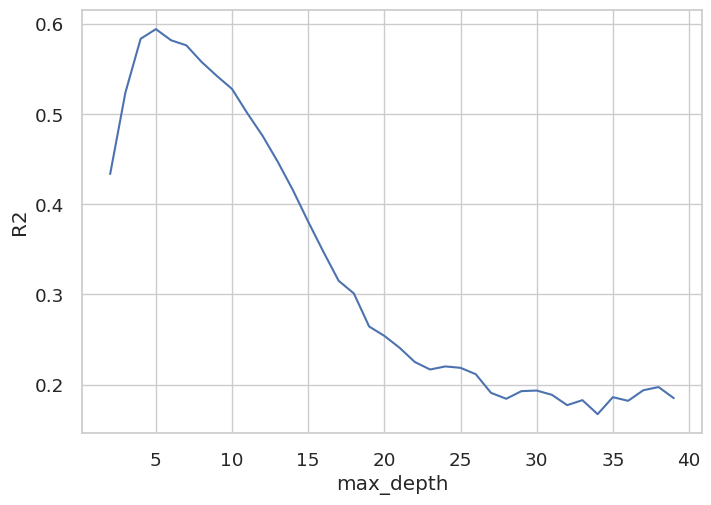

In [154]:
# Visualize which max_depth leads to the highest r2 score
import matplotlib.pyplot as plt
plt.plot(depths, scores['Test Score'])
plt.xlabel('max_depth')
plt.ylabel('R2');

In [155]:
# Sort by Best result on Test Data
sorted_scores = scores.sort_values(by='Test Score', ascending=False)
sorted_scores.head()

,Test Score,Train Score
5,0.59471,0.60394
4,0.584005,0.582625
6,0.582326,0.615161
7,0.576718,0.626843
8,0.558305,0.643832


In [156]:
# Let's run the model with our optimized value for max_depth
dec_tree_5 = DecisionTreeRegressor(max_depth = 5, random_state = 42)

# Fit on the training data
dec_tree_5.fit(X_train_transformed, y_train)

# Get predictions
train_preds = dec_tree_5.predict(X_train_transformed)
test_preds = dec_tree_5.predict(X_test_transformed)



###Evalute model after tuning

In [157]:
# evaluate the model
train_5_score = r2_score(y_train, train_preds)
test_5_score = r2_score(y_test, test_preds)
print(f'Model Training R2: {train_5_score:.2f}')
print(f'Model Testing R2: {test_5_score:.2f}')


Model Training R2: 0.60
Model Testing R2: 0.59


In [158]:
# Calculating RMSE with sklearn
train_RMSE_5_score = mean_squared_error(y_train, train_preds, squared=False)
test_RMSE_5_score = mean_squared_error(y_test, test_preds, squared=False)
print(f'Model Training RMSE: {train_RMSE_5_score:,.2f}')
print(f'Model Testing RMSE: {test_RMSE_5_score:,.2f}')

Model Training RMSE: 1,082.65
Model Testing RMSE: 1,057.44


##overview

- **Linear Regression Model:**
  - Training RMSE: 1,139.10
  - Testing RMSE: 1,092.90
  - Training R2: 0.56
  - Testing R2: 0.57
- **Regression Tree Model (Before Tuning):**
  - Training R2: 1.00
  - Testing R2: 0.18
  - Training RMSE: 0.00
  - Testing RMSE: 1,503.67
- **Regression Tree Model (After Tuning):**
  - Training R2: 0.60
  - Testing R2: 0.59
  - Training RMSE: 1,082.65
  - Testing RMSE: 1,057.44

##Analysis:


- **Linear Regression:**

The linear regression model demonstrates moderate performance, as evidenced by R2 values of 0.56 (training) and 0.57 (testing). The RMSE values hovering around 1,100 suggest a balance between bias and variance, indicative of a reasonable trade-off in handling errors in sales prediction.

- **Regression Tree (Before Tuning):**

The regression tree model, in its initial state, exhibits signs of overfitting. The perfect R2 value of 1.00 on the training set signifies an overemphasis on capturing the intricacies of the data, leading to poor generalization on the testing set with an R2 of 0.18. This imbalance between bias and variance is characteristic of overfitting.

- **Regression Tree (After Tuning):**

Post-tuning, the regression tree model achieves a more harmonious balance between bias and variance. The R2 values for both training and testing sets become more aligned at 0.60 and 0.59, respectively. The reduction in RMSE values reflects improved predictive performance and an alleviation of overfitting tendencies, resulting in a model that generalizes well to new data.



---


- **Recommendation:**


---


Based on the provided information, the tuned regression tree model seems to be the better choice for your sales prediction task. It demonstrates improved generalization performance compared to the untuned regression tree and comparable performance to the linear regression model. The tuning process has helped alleviate overfitting, resulting in a model that performs well on both training and testing sets.

To further enhance predictive capabilities, we can also consider exploring alternative regression methods, like bagging regression. Additionally, experimenting with multiple tuning approaches may reveal further refinements or alternative models better suited to the stockholder sale prediction goals.